## Regressions at the country level

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import seaborn as sns
import numpy as np
from stargazer.stargazer import Stargazer

xr.set_options(display_expand_attrs=False, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

In [2]:
data = pd.read_csv('data.csv')
data.head()

,time,region,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,equation,damage,log_gross_domestic_product_nominal,log_temperature_change,log_coef,log_damage,index,pop_est,REGIONS 35 I
0,2005.0,BELGIUM,0.582127,47277.739995,1.714491,0.686361,0.845,458081.623996,24767.399895,define_tot_eq_define_total_impact,644.310354,13.034803,-0.168419,-0.376352,6.468181,Belgium,11484055.0,BELGIUM
1,2005.0,BULGARIA,0.582127,47277.739995,1.714491,0.247350,0.845,49342.067424,4290.060541,define_tot_eq_define_total_impact,25.010835,10.806532,-0.168419,-1.396953,3.219309,Bulgaria,6975761.0,BULGARIA
2,2005.0,CROATIA,0.582127,47277.739995,1.714491,0.344144,0.845,49378.731850,7565.730576,define_tot_eq_define_total_impact,34.824074,10.807275,-0.168419,-1.066696,3.550309,Croatia,4067500.0,CROATIA
3,2005.0,CYPRUS,0.582127,47277.739995,1.714491,0.516904,0.845,20251.576648,15217.411656,define_tot_eq_define_total_impact,21.452018,9.915988,-0.168419,-0.659899,3.065819,Cyprus,1198575.0,CYPRUS
4,2005.0,DENMARK,0.582127,47277.739995,1.714491,0.746531,0.845,296616.284738,28613.689785,define_tot_eq_define_total_impact,453.777313,12.600195,-0.168419,-0.292318,6.117607,Denmark,5818553.0,DENMARK


In [3]:
data['equation'].unique()

array(['define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact',
       'witness_tot_eq_witness_total_impact'], dtype=object)

In [4]:
df_melted = pd.read_csv('df_melted.csv')
df_melted.shape

(5595, 11)

### General model

As explained in the conceptual framework, our goal here is to quantifiy how important are each factors in terms of explaining the variation of the explained variable. 

We have distinguished three types of parameters : 

- **physical parameters**, such as temperature, carbon dioxyide concentration, radiative forcing, etc. These directly represent the physical aspect of climate change
- **methodological parameters**, such as the model used, the number of variables, the level of complexity, etc. These represent parameters that rely with the model, from a technical prospective
- **ethical parameters**, such as the discount rate, the normalisation factor or other parameters that take account of ethical considerations

We argue that an integrated assessment model is composed of these three types of parameters. The role of physical variables in the functionning of the model is its primary purpose; the variation between one model and another one has been widely discussed and quantified in the litterature. However, we believe that the ethical variables play a significant role in the determination of the output of the model. 

Hence, we define an econometric model to asses the role of each of the variables in the output of the model. 

The explained variable is the level of damage. Indeed, it is the primary goal of damage functions to assess the level of damages, so we have comparable values  accros models. Moreover, it is a quantified value, so it allows a quantitative evaluation. 

We consider a linear model. The explained variables are a combination of physical, methodological and ethical variables. 

### Simple model : only temperature change

In [5]:
reg_temp = smf.ols('log_damage ~ temperature_change', data=data).fit()
reg_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                 1.065e+05
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:53:07   Log-Likelihood:            -5.1169e+05
No. Observations:              231378   AIC:                         1.023e+06
Df Residuals:                  231376   BIC:                         1.023e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.9086      0.015    253.705      0.000       3.878       3.939
temperature_change     2.8401      0.009    326.400      0.000       2.823       2.857
==============================================================================
Omnibus:                     9880.123   Durbin-Watson:                   1.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11261.816
Skew:                           0.516   Prob(JB):                         0.00
Kurtosis:                       3.318   Cond. No.                         7.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Second model : temperature and ethical coefficient

In [6]:
# Regressing
reg_simple = sm.OLS(data['log_damage'], sm.add_constant(data[['temperature_change', 'log_coef']])).fit()
reg_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                 1.088e+05
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:53:07   Log-Likelihood:            -4.7880e+05
No. Observations:              231378   AIC:                         9.576e+05
Df Residuals:                  231375   BIC:                         9.576e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9278      0.013    293.888      0.000       3.902       3.954
temperature_change     2.8367      0.008    375.805      0.000       2.822       2.852
log_coef               1.0005      0.004    275.832      0.000       0.993       1.008
==============================================================================
Omnibus:                    12213.874   Durbin-Watson:                   1.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14266.583
Skew:                           0.608   Prob(JB):                         0.00
Kurtosis:                       2.958   Cond. No.                         7.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Third model : what about equations ? 

In [7]:
# Adding a dummy for the equation 
data_dummy = pd.get_dummies(data, columns=['equation'], drop_first=True)
dummy_equations = [col for col in data_dummy.columns if 'equation_' in col]
data_dummy[dummy_equations] = data_dummy[dummy_equations].astype('int')

# Adding a dummy for the region
data_dummy = pd.get_dummies(data_dummy, columns=['region'], drop_first=True)
dummy_regions = [col for col in data_dummy.columns if 'region_' in col]
data_dummy[dummy_regions] = data_dummy[dummy_regions].astype('int')

# Est-ce que c'est un problème de retirer la première valeur à chaque fois ? ca veut dire qu'on retire quand même un tiers des données => en fait non parce que les dummy sont en colonnes et pas en ligne

# Regressing
reg_equation = sm.OLS(data_dummy['log_damage'], sm.add_constant(data_dummy[['temperature_change', 'log_coef'] + dummy_equations])).fit()
reg_equation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 5.599e+04
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:53:07   Log-Likelihood:            -4.7718e+05
No. Observations:              231378   AIC:                         9.544e+05
Df Residuals:                  231373   BIC:                         9.544e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            3.8765      0.014    269.142      0.000       3.848       3.905
temperature_change                               2.8367      0.007    378.437      0.000       2.822       2.851
log_coef                                         1.0005      0.004    277.763      0.000       0.993       1.008
equation_dice_tot_eq_dice_total_impact          -0.1958      0.010    -20.207      0.000      -0.215      -0.177
equation_witness_tot_eq_witness_total_impact     0.3498      0.010     36.095      0.000       0.331       0.369
==============================================================================
Omnibus:                    12672.876   Durbin-Watson:                   1.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14888.468
Skew:                           0.621   Prob(JB):                         0.00
Kurtosis:                       2.958   Cond. No.                         8.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Explaining the level of damage as a linear model of temperature change, the model choice and the ethical coefficient, is a very weak explanation. We obtain a R2 of 0.073, which is very low and let us think there is absolutely no relationship between the level of damage and the explaining variables. 

This is to be further investigated, since we know there is a relationship between these two : at least, there is a relationship between climate variable such as temperature change, and the level of damage. 

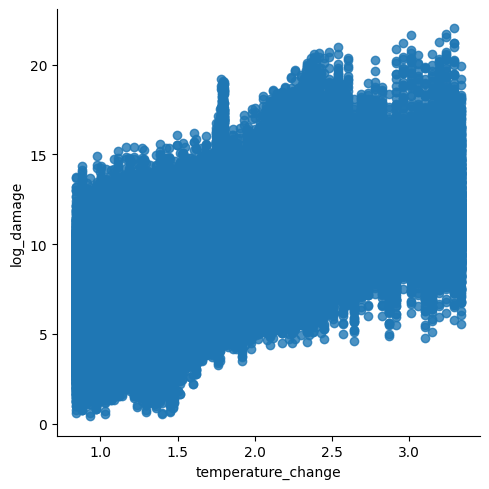

In [8]:
sns.lmplot(x='temperature_change', y='log_damage', data=data_dummy)

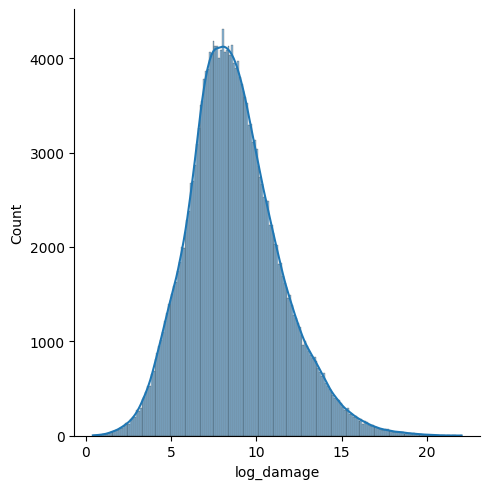

In [9]:
#damage_high = data[data['total_damage'] < 10000]
sns.displot(data, x='log_damage', kde=True)

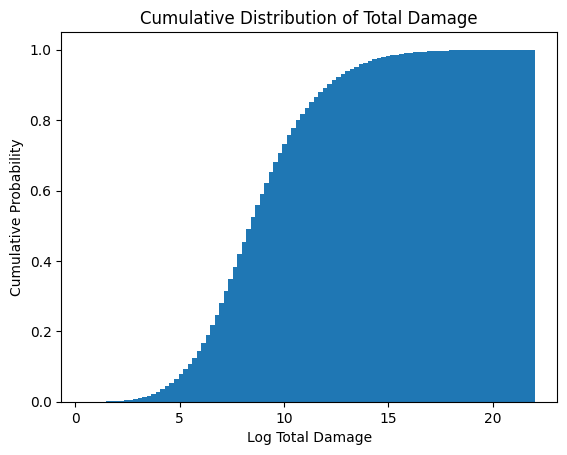

In [10]:
import matplotlib.pyplot as plt

plt.hist(data['log_damage'], bins=100, cumulative=True, density=True)
plt.xlabel('Log Total Damage')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Total Damage')
plt.show()

### Fourth model : what about regions ? 

Let's try by having a dummy by region.

In [11]:
# Regressing
reg_country = sm.OLS(data_dummy['log_damage'], sm.add_constant(data_dummy[['temperature_change', 'log_coef'] + dummy_regions])).fit()
reg_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 2.050e+05
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:53:27   Log-Likelihood:            -1.9654e+05
No. Observations:              231378   AIC:                         3.931e+05
Df Residuals:                  231353   BIC:                         3.934e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.8357      0.007    702.996      0.000       4.822       4.849
temperature_change     2.8638      0.002   1284.336      0.000       2.859       2.868
log_coef               1.0027      0.001    936.240      0.000       1.001       1.005
region_BULGARIA       -2.6530      0.008   -325.390      0.000      -2.669      -2.637
region_CHINA           3.6142      0.008    443.830      0.000       3.598       3.630
region_CROATIA        -2.5834      0.008   -318.328      0.000      -2.599      -2.567
region_CYPRUS         -3.6812      0.008   -453.468      0.000      -3.697      -3.665
region_DENMARK        -0.5293      0.008    -64.799      0.000      -0.545      -0.513
region_ESTONIA        -3.1396      0.008   -387.020      0.000      -3.156      -3.124
region_FINLAND        -0.8692      0.008   -106.361      0.000      -0.885      -0.853
region_FRANCE          1.3279      0.008    163.706      0.000       1.312       1.344
region_GERMANY         2.2478      0.008    272.899      0.000       2.232       2.264
region_GREECE         -1.6359      0.008   -201.730      0.000      -1.652      -1.620
region_HUNGARY        -1.8680      0.008   -230.078      0.000      -1.884      -1.852
region_INDIA           0.7400      0.009     84.430      0.000       0.723       0.757
region_IRELAND        -0.8576      0.008   -105.793      0.000      -0.873      -0.842
region_LATVIA         -2.8925      0.007   -410.805      0.000      -2.906      -2.879
region_LITHUANIA      -2.7710      0.008   -341.805      0.000      -2.787      -2.755
region_LUXEMBOURG     -1.9293      0.008   -231.743      0.000      -1.946      -1.913
region_POLAND          0.1483      0.008     18.264      0.000       0.132       0.164
region_PORTUGAL       -1.2887      0.008   -158.961      0.000      -1.305      -1.273
region_RUSSIA          1.2160      0.008    149.846      0.000       1.200       1.232
region_SLOVAKIA       -2.0861      0.008   -257.211      0.000      -2.102      -2.070
region_SPAIN           0.2154      0.008     26.566      0.000       0.200       0.231
region_SWEDEN         -0.1152      0.008    -14.176      0.000      -0.131      -0.099
==============================================================================
Omnibus:                    17504.792   Durbin-Watson:                   0.418
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33796.690
Skew:                           0.531   Prob(JB):                         0.00
Kurtosis:                       4.541   Cond. No.                         48.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fifth model : putting it all together

Let's now try with both dummy variables for the region and for the equation. 

In [12]:
# Regressing
reg_double = sm.OLS(data_dummy['log_damage'], sm.add_constant(data_dummy[['temperature_change', 'log_coef'] + dummy_equations + dummy_regions])).fit()
reg_double.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 2.267e+05
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:53:28   Log-Likelihood:            -1.7649e+05
No. Observations:              231378   AIC:                         3.530e+05
Df Residuals:                  231351   BIC:                         3.533e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            4.7844      0.006    737.224      0.000       4.772       4.797
temperature_change                               2.8638      0.002   1400.561      0.000       2.860       2.868
log_coef                                         1.0027      0.001   1020.965      0.000       1.001       1.005
equation_dice_tot_eq_dice_total_impact          -0.1958      0.003    -74.109      0.000      -0.201      -0.191
equation_witness_tot_eq_witness_total_impact     0.3498      0.003    132.379      0.000       0.345       0.355
region_BULGARIA                                 -2.6530      0.007   -354.836      0.000      -2.668      -2.638
region_CHINA                                     3.6142      0.007    483.994      0.000       3.600       3.629
region_CROATIA                                  -2.5834      0.007   -347.135      0.000      -2.598      -2.569
region_CYPRUS                                   -3.6812      0.007   -494.504      0.000      -3.696      -3.667
region_DENMARK                                  -0.5293      0.007    -70.663      0.000      -0.544      -0.515
region_ESTONIA                                  -3.1396      0.007   -422.043      0.000      -3.154      -3.125
region_FINLAND                                  -0.8692      0.007   -115.986      0.000      -0.884      -0.855
region_FRANCE                                    1.3279      0.007    178.520      0.000       1.313       1.343
region_GERMANY                                   2.2478      0.008    297.595      0.000       2.233       2.263
region_GREECE                                   -1.6359      0.007   -219.986      0.000      -1.650      -1.621
region_HUNGARY                                  -1.8680      0.007   -250.899      0.000      -1.883      -1.853
region_INDIA                                     0.7400      0.008     92.071      0.000       0.724       0.756
region_IRELAND                                  -0.8576      0.007   -115.366      0.000      -0.872      -0.843
region_LATVIA                                   -2.8925      0.006   -447.981      0.000      -2.905      -2.880
region_LITHUANIA                                -2.7710      0.007   -372.737      0.000      -2.786      -2.756
region_LUXEMBOURG                               -1.9293      0.008   -252.714      0.000      -1.944      -1.914
region_POLAND                                    0.1483      0.007     19.917      0.000       0.134       0.163
region_PORTUGAL                                 -1.2887      0.007   -173.346      0.000      -1.303      -1.274
region_RUSSIA                                    1.2160      0.007    163.406      0.000       1.201       1.231
region_SLOVAKIA                 

We check the residuals distribution : they are clearly correlated with the region. 

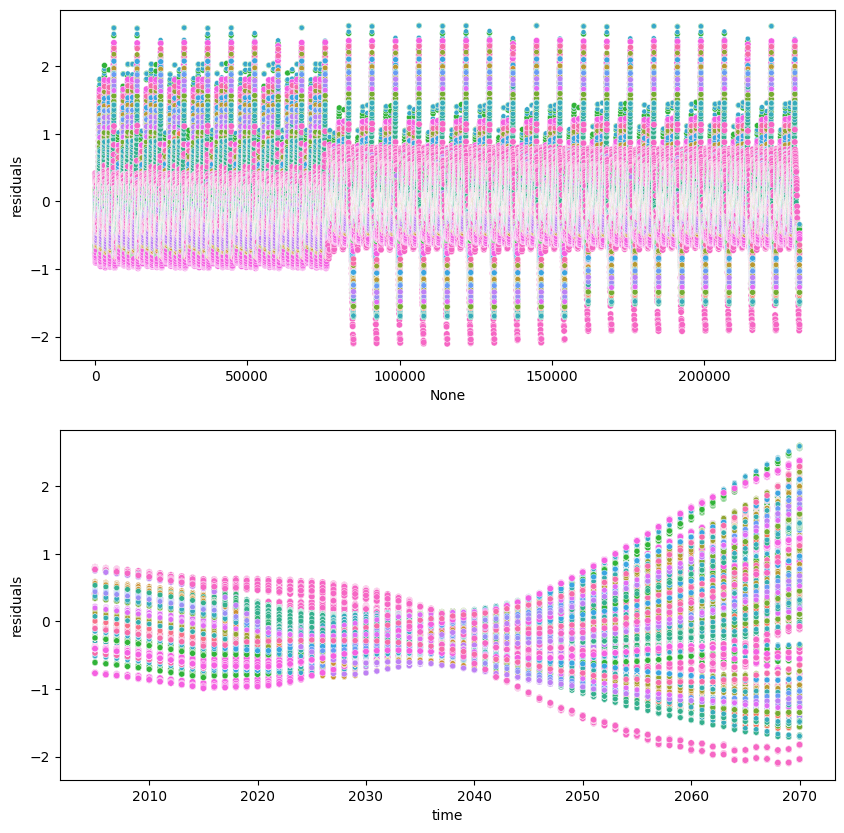

In [13]:
residuals = reg_double.resid

#joint = residuals.join(data_dummy[['temperature_change', 'coef'] + dummy_equations + dummy_regions])
data['residuals'] = residuals

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

sns.scatterplot(data=data, x=data.index, y='residuals', hue='region', s=np.log(data['pop_est']), legend=False, ax=axs[0])
sns.scatterplot(data=data, x='time', y='residuals', hue='region', s=np.log(data['pop_est']), legend=False, ax=axs[1])

#residuals.plot(ax=ax, color='black', alpha=0.5)

plt.show()


In [14]:
bp_test = het_breuschpagan(reg_double.resid, reg_double.model.exog)
white_test = het_white(reg_double.resid, reg_double.model.exog)
white_test[1]

0.0

<Axes: xlabel='None', ylabel='log_damage'>

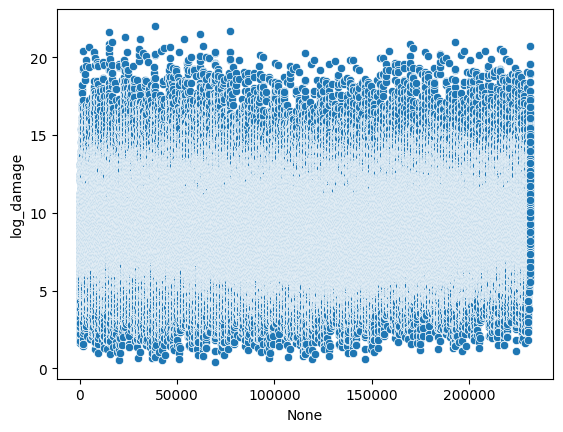

In [15]:
sns.scatterplot(data=data_dummy, x=data_dummy.index, y='log_damage')

In [16]:
robust_model = reg_double.get_robustcov_results()
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 1.686e+05
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:53:48   Log-Likelihood:            -1.7649e+05
No. Observations:              231378   AIC:                         3.530e+05
Df Residuals:                  231351   BIC:                         3.533e+05
Df Model:                          26                                         
Covariance Type:                  HC1                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            4.7844      0.007    685.621      0.000       4.771       4.798
temperature_change                               2.8638      0.003   1070.661      0.000       2.859       2.869
log_coef                                         1.0027      0.001    793.637      0.000       1.000       1.005
equation_dice_tot_eq_dice_total_impact          -0.1958      0.003    -72.885      0.000      -0.201      -0.191
equation_witness_tot_eq_witness_total_impact     0.3498      0.003    131.892      0.000       0.345       0.355
region_BULGARIA                                 -2.6530      0.007   -385.825      0.000      -2.667      -2.640
region_CHINA                                     3.6142      0.009    392.456      0.000       3.596       3.632
region_CROATIA                                  -2.5834      0.007   -368.789      0.000      -2.597      -2.570
region_CYPRUS                                   -3.6812      0.008   -484.731      0.000      -3.696      -3.666
region_DENMARK                                  -0.5293      0.007    -74.318      0.000      -0.543      -0.515
region_ESTONIA                                  -3.1396      0.007   -442.593      0.000      -3.154      -3.126
region_FINLAND                                  -0.8692      0.008   -113.347      0.000      -0.884      -0.854
region_FRANCE                                    1.3279      0.007    195.763      0.000       1.315       1.341
region_GERMANY                                   2.2478      0.009    261.156      0.000       2.231       2.265
region_GREECE                                   -1.6359      0.007   -225.504      0.000      -1.650      -1.622
region_HUNGARY                                  -1.8680      0.007   -270.696      0.000      -1.882      -1.854
region_INDIA                                     0.7400      0.009     85.778      0.000       0.723       0.757
region_IRELAND                                  -0.8576      0.007   -124.477      0.000      -0.871      -0.844
region_LATVIA                                   -2.8925      0.006   -453.488      0.000      -2.905      -2.880
region_LITHUANIA                                -2.7710      0.007   -411.640      0.000      -2.784      -2.758
region_LUXEMBOURG                               -1.9293      0.009   -219.408      0.000      -1.946      -1.912
region_POLAND                                    0.1483      0.008     19.234      0.000       0.133       0.163
region_PORTUGAL                                 -1.2887      0.007   -179.417      0.000      -1.303      -1.275
region_RUSSIA                                    1.2160      0.008    159.254      0.000       1.201       1.231
region_SLOVAKIA                 

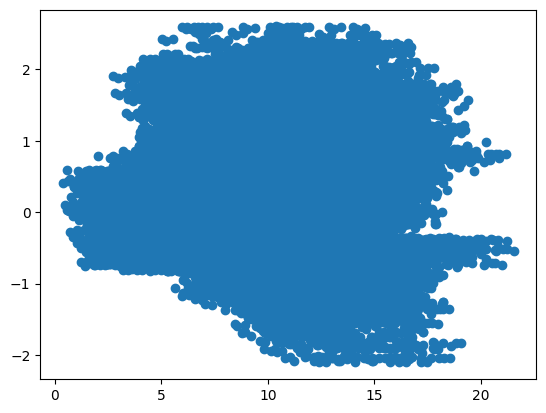

In [17]:
plt.scatter(reg_double.fittedvalues, reg_double.resid)

In [18]:
df_residuals = pd.DataFrame({'Fitted Values': reg_double.fittedvalues, 'Residuals': reg_double.resid})
df_residuals

,Fitted Values,Residuals
0,6.826912,-0.358731
1,3.150552,0.068757
2,3.551362,-0.001053
3,2.861443,0.204376
4,6.381874,-0.264268
...,...,...
231373,14.327180,-1.125901
231374,13.671904,-1.267337
231375,17.375456,-0.553066
231376,16.763534,-1.822321


In [19]:
i = 0 
print(np.linspace((10*i), (10*(i+1)), 6))

[ 0.  2.  4.  6.  8. 10.]


0.0
2.0
4.0
6.0
8.0
10.0
10.0
12.0
14.0
16.0
18.0
20.0


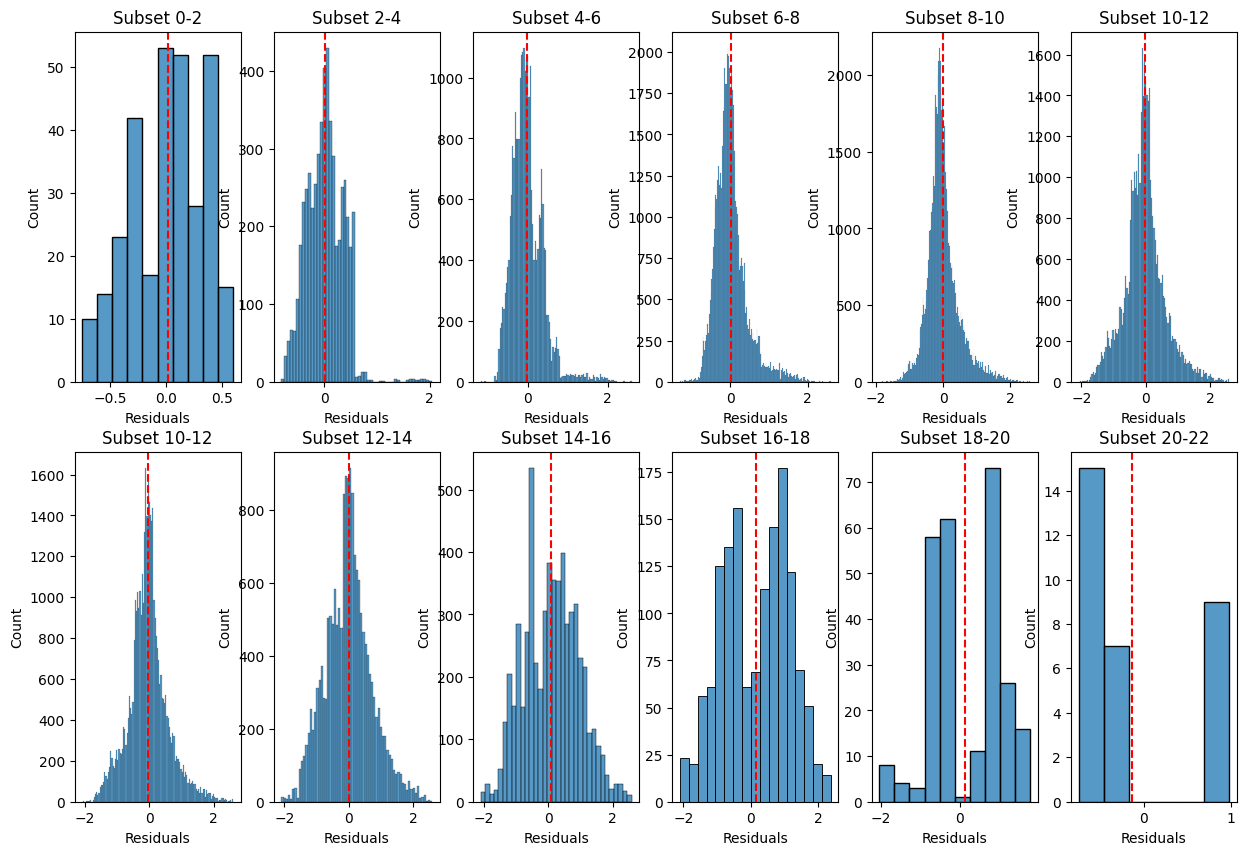

In [20]:
df_residuals = pd.DataFrame({'Fitted Values': reg_double.fittedvalues, 'Residuals': reg_double.resid})

fig, axs = plt.subplots(2, 6, figsize=(15, 10))

for i in range(0, 2, 1): 
    #print(i)
    for j, x in enumerate(np.linspace(10*i, (10*(i+1)), 6)) :
        print(x) 
        subset = df_residuals[(df_residuals['Fitted Values'] > x) & (df_residuals['Fitted Values'] < x + 2)]

        sns.histplot(data=subset, x='Residuals', ax=axs[i, j])
        axs[i, j].set_title(f"Subset {int(x)}-{int(x+2)}")
        axs[i, j].axvline(subset['Residuals'].mean(), color='red', linestyle='--')

fig.savefig('../../../../Memoire/results/slr_4.png', dpi=300)
plt.show()

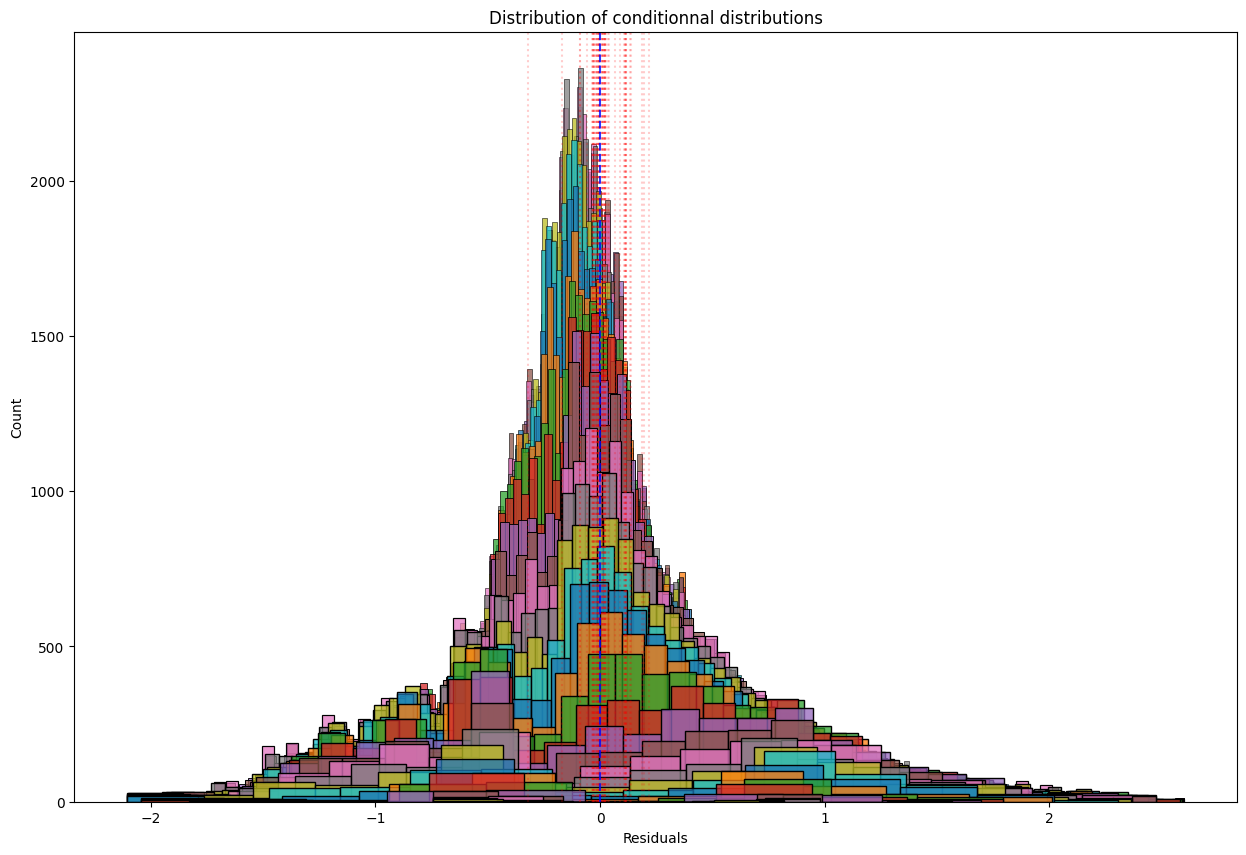

In [21]:
df_residuals = pd.DataFrame({'Fitted Values': reg_double.fittedvalues, 'Residuals': reg_double.resid})

fig, axs = plt.subplots(1, 1, figsize=(15, 10))

for j, x in enumerate(np.linspace(0, 21, 50)) : 
    subset = df_residuals[(df_residuals['Fitted Values'] > x) & (df_residuals['Fitted Values'] < x + 2)]

    sns.histplot(data=subset, x='Residuals', ax=axs)
    axs.axvline(subset['Residuals'].mean(), color='red', linestyle='dotted', alpha=0.2)

axs.set_title(f"Distribution of conditionnal distributions")


axs.axvline(df_residuals['Residuals'].mean(), color='blue', linestyle='--', alpha=0.8)


fig.savefig('../../../../Memoire/results/slr_4_2.png', dpi=300)
plt.show()

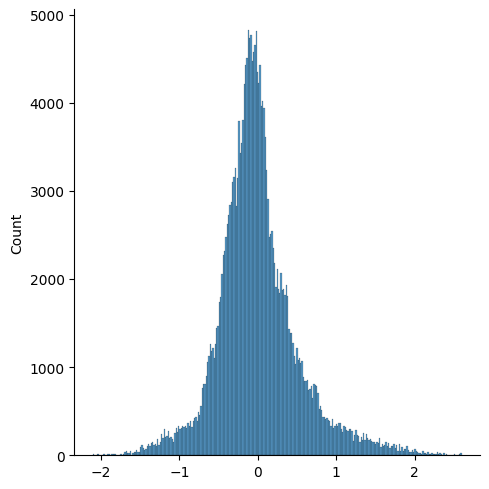

In [22]:
sns.displot(reg_double.resid)

To the table.

### Summary table

In [23]:
def clean_latex_table(latex_code):
    latex_code = latex_code.replace('_', r'\_')
    latex_code = latex_code.replace(r'\begin{table}[!htbp] \centering', r' ')
    latex_code = latex_code.replace(r'\end{table}', r' ')
    #latex_code = latex_code.replace(r'\begin{tabular}', r'\centering\begin{tabular}')

    return latex_code


In [24]:
# Creating the stargazer object
stargazer = Stargazer([reg_temp, reg_equation, reg_country, reg_double])

# Customizing the table
#stargazer.title('Résultats de la régression')
stargazer.show_model_numbers(True)
stargazer.cov_spacing = 2

# Showing everthing except countries
variables_to_show = ['temperature_change', 'log_coef'] + dummy_equations
stargazer.covariate_order(variables_to_show)

# Customizing the columns and lines titles
stargazer.custom_columns(['Temp', 'Equation', 'Country', 'Double'], [1, 1, 1, 1])
stargazer.rename_covariates({'temperature_change': 'Temperature Change',
                              'coef': 'Ethical coefficient', 
                              'equation': 'Model',
                              'region': 'Region', 
                              'equation_dice_tot_eq_dice_total_impact': 'DICE form damage function',
                              'equation_witness_tot_eq_witness_total_impact': 'WITNESS form damage function',})


stargazer.add_line('Regional dummy', ['No', 'No', 'Yes', 'Yes'])



#stargazer.add_custom_notes(['This is a note'])

# Rendering to latex to include in the report
latex_code=stargazer.render_latex()
latex_code = clean_latex_table(latex_code)
# Saving it to the report folder
with open('../../../../Memoire/results/regression_1.tex', 'w') as f:
    f.write(latex_code)

# Showing the table
stargazer


In [25]:
print(latex_code)

 
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable: log\_damage}} \
\cr \cline{2-5}
\\[-1.8ex] & \multicolumn{1}{c}{Temp} & \multicolumn{1}{c}{Equation} & \multicolumn{1}{c}{Country} & \multicolumn{1}{c}{Double}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Temperature Change & 2.840$^{***}$ & 2.837$^{***}$ & 2.864$^{***}$ & 2.864$^{***}$ \\
& (0.009) & (0.007) & (0.002) & (0.002) \\[2em]
 log\_coef & & 1.000$^{***}$ & 1.003$^{***}$ & 1.003$^{***}$ \\
& & (0.004) & (0.001) & (0.001) \\[2em]
 DICE form damage function & & -0.196$^{***}$ & & -0.196$^{***}$ \\
& & (0.010) & & (0.003) \\[2em]
 WITNESS form damage function & & 0.350$^{***}$ & & 0.350$^{***}$ \\
& & (0.010) & & (0.003) \\[2em]
 Regional dummy & No & No & Yes & Yes \\
\hline \\[-1.8ex]
 Observations & 231378 & 231378 & 231378 & 231378 \\
 $R^2$ & 0.315 & 0.492 & 0.955 & 0.962 \\
 Adjusted $R^2$ & 0.315 & 0.492 & 0.955 & 0.962 \\
 Resid

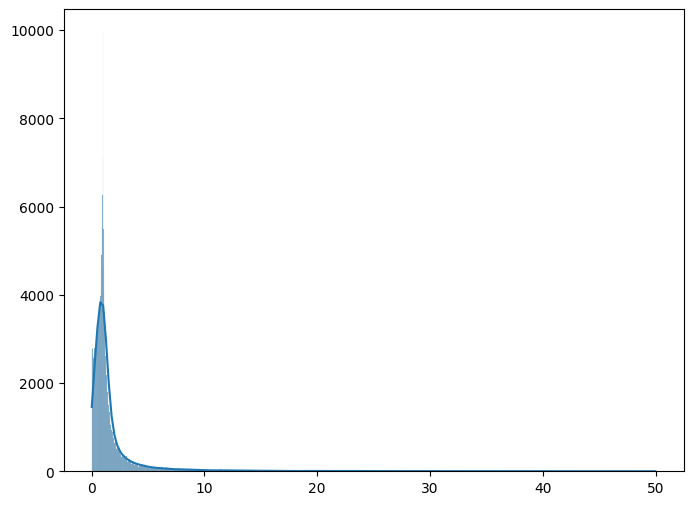

In [26]:
import matplotlib.pyplot as plt

# Créer une figure
fig, ax = plt.subplots(figsize=(8, 6))


sns.histplot(data=data, x='coef', kde=True, ax=ax)

# Remove the x-label and y-label
ax.set_xlabel('')
ax.set_ylabel('')

# Enregistrer la figure
fig.savefig('../../../../Memoire/results/coef.png', dpi=300)

## Regressions at the global level

In [27]:
damage_aggregated = pd.read_csv('damage_aggregated.csv')
damage_aggregated

,time,equation,Run,damage,gross_domestic_product_nominal,total_radiative_forcing,temperature_change,exponent,constant,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact,log_exponent,log_damage,log_constant
0,2005.0,define_tot_eq_define_total_impact,0,7.450947e+04,7.153753e+07,1.714491,0.845000,0.582127,47277.739995,False,False,-0.541067,11.218682,10.763795
1,2005.0,define_tot_eq_define_total_impact,1,9.040747e+05,6.011960e+07,1.901000,0.845000,-2.121818,25090.060841,False,False,NaN,13.714667,10.130227
2,2005.0,define_tot_eq_define_total_impact,2,8.031957e+04,7.153753e+07,1.905000,0.845000,1.006430,30769.251023,False,False,0.006409,11.293769,10.334271
3,2005.0,define_tot_eq_define_total_impact,3,9.675407e+04,7.153753e+07,1.904000,0.845000,0.835711,26448.878637,False,False,-0.179472,11.479928,10.182969
4,2005.0,define_tot_eq_define_total_impact,4,1.480256e+05,7.153753e+07,1.906000,0.845000,-0.118945,12024.511041,False,False,NaN,11.905140,9.394702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,2070.0,witness_tot_eq_witness_total_impact,45,6.717711e+07,1.177401e+09,4.784617,2.603701,-1.332942,48087.730499,False,True,NaN,18.022843,10.780782
9896,2070.0,witness_tot_eq_witness_total_impact,46,2.825308e+07,1.513754e+09,4.443000,2.429880,-0.878792,33078.247973,False,True,NaN,17.156713,10.406631
9897,2070.0,witness_tot_eq_witness_total_impact,47,6.564956e+07,1.498663e+09,4.188000,2.413231,0.090598,40230.958488,False,True,-2.401321,17.999842,10.602392
9898,2070.0,witness_tot_eq_witness_total_impact,48,2.952544e+07,1.159378e+09,2.854000,1.799231,-1.290950,49412.592003,False,True,NaN,17.200763,10.807961


In [28]:
equation_columns = [col for col in damage_aggregated.columns if 'equation_' in col]
damage_aggregated[equation_columns] = damage_aggregated[equation_columns].astype('int')
equation_columns

['equation_dice_tot_eq_dice_total_impact',
 'equation_witness_tot_eq_witness_total_impact']

In [29]:
# Replace inf values with nan
damage_aggregated.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with nan values
damage_aggregated.dropna(inplace=True)

# Display the cleaned DataFrame
damage_aggregated.head()

,time,equation,Run,damage,gross_domestic_product_nominal,total_radiative_forcing,temperature_change,exponent,constant,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact,log_exponent,log_damage,log_constant
0,2005.0,define_tot_eq_define_total_impact,0,74509.471310,7.153753e+07,1.714491,0.845,0.582127,47277.739995,0,0,-0.541067,11.218682,10.763795
2,2005.0,define_tot_eq_define_total_impact,2,80319.573779,7.153753e+07,1.905000,0.845,1.006430,30769.251023,0,0,0.006409,11.293769,10.334271
3,2005.0,define_tot_eq_define_total_impact,3,96754.067933,7.153753e+07,1.904000,0.845,0.835711,26448.878637,0,0,-0.179472,11.479928,10.182969
5,2005.0,define_tot_eq_define_total_impact,5,277962.296990,7.153753e+07,1.714491,0.845,1.462359,12227.761330,0,0,0.380051,12.535241,9.411464
6,2005.0,define_tot_eq_define_total_impact,6,57906.412506,6.011960e+07,1.901000,0.845,1.747002,33963.519571,0,0,0.557901,10.966583,10.433042


### Regressing only with temperature change

In [30]:
reg_global_temp = sm.OLS(damage_aggregated['log_damage'], sm.add_constant(damage_aggregated[['temperature_change']])).fit()
reg_global_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                 2.372e+04
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:54:03   Log-Likelihood:                -7181.5
No. Observations:                5073   AIC:                         1.437e+04
Df Residuals:                    5071   BIC:                         1.438e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.0852      0.047    171.474      0.000       7.993       8.178
temperature_change     4.0831      0.027    154.015      0.000       4.031       4.135
==============================================================================
Omnibus:                      579.196   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1106.998
Skew:                           0.742   Prob(JB):                    4.15e-241
Kurtosis:                       4.742   Cond. No.                         7.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regressing with multiple parameters

In [31]:
reg_global_simple = sm.OLS(damage_aggregated['log_damage'], sm.add_constant(damage_aggregated[['temperature_change', 'exponent', 'constant']])).fit()
reg_global_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     9423.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:54:03   Log-Likelihood:                -6808.6
No. Observations:                5073   AIC:                         1.363e+04
Df Residuals:                    5069   BIC:                         1.365e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.5355      0.057    149.003      0.000       8.423       8.648
temperature_change     4.1115      0.025    166.731      0.000       4.063       4.160
exponent               0.3624      0.021     17.171      0.000       0.321       0.404
constant           -2.576e-05   1.13e-06    -22.774      0.000    -2.8e-05   -2.35e-05
==============================================================================
Omnibus:                      578.090   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1528.324
Skew:                           0.639   Prob(JB):                         0.00
Kurtosis:                       5.365   Cond. No.                     1.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Simple logged

In [32]:
reg_global_simple_logged = sm.OLS(damage_aggregated['log_damage'], sm.add_constant(damage_aggregated[['temperature_change', 'log_exponent', 'log_constant']])).fit()
reg_global_simple_logged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     9379.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:54:03   Log-Likelihood:                -6818.8
No. Observations:                5073   AIC:                         1.365e+04
Df Residuals:                    5069   BIC:                         1.367e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.1584      0.309     48.991      0.000      14.552      15.765
temperature_change     4.1102      0.025    166.355      0.000       4.062       4.159
log_exponent           0.1883      0.011     17.113      0.000       0.167       0.210
log_constant          -0.6827      0.030    -22.732      0.000      -0.742      -0.624
==============================================================================
Omnibus:                      599.654   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1454.294
Skew:                           0.687   Prob(JB):                         0.00
Kurtosis:                       5.234   Cond. No.                         249.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Adding the equation dummies

In [33]:
reg_global_eq = sm.OLS(damage_aggregated['log_damage'], sm.add_constant(damage_aggregated[['temperature_change', 'exponent', 'constant'] + equation_columns])).fit()
reg_global_eq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     6071.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:54:03   Log-Likelihood:                -6653.8
No. Observations:                5073   AIC:                         1.332e+04
Df Residuals:                    5067   BIC:                         1.336e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            8.4881      0.058    145.424      0.000       8.374       8.602
temperature_change                               4.1115      0.024    171.866      0.000       4.065       4.158
exponent                                         0.3624      0.020     17.700      0.000       0.322       0.403
constant                                     -2.576e-05    1.1e-06    -23.475      0.000   -2.79e-05   -2.36e-05
equation_dice_tot_eq_dice_total_impact          -0.2018      0.031     -6.529      0.000      -0.262      -0.141
equation_witness_tot_eq_witness_total_impact     0.3441      0.031     11.133      0.000       0.284       0.405
==============================================================================
Omnibus:                      671.233   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1958.652
Skew:                           0.704   Prob(JB):                         0.00
Kurtosis:                       5.699   Cond. No.                     1.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
reg_global_eq_logged = sm.OLS(damage_aggregated['log_damage'], sm.add_constant(damage_aggregated[['temperature_change', 'log_exponent', 'log_constant'] + equation_columns])).fit()
reg_global_eq_logged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     6041.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:54:04   Log-Likelihood:                -6664.5
No. Observations:                5073   AIC:                         1.334e+04
Df Residuals:                    5067   BIC:                         1.338e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           15.1110      0.301     50.246      0.000      14.521      15.701
temperature_change                               4.1102      0.024    171.456      0.000       4.063       4.157
log_exponent                                     0.1883      0.011     17.638      0.000       0.167       0.209
log_constant                                    -0.6827      0.029    -23.429      0.000      -0.740      -0.626
equation_dice_tot_eq_dice_total_impact          -0.2018      0.031     -6.515      0.000      -0.263      -0.141
equation_witness_tot_eq_witness_total_impact     0.3441      0.031     11.109      0.000       0.283       0.405
==============================================================================
Omnibus:                      696.408   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1856.274
Skew:                           0.756   Prob(JB):                         0.00
Kurtosis:                       5.548   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### With explanatory variables logged

In [35]:
reg_global_eq_log = sm.OLS(damage_aggregated['log_damage'], sm.add_constant(damage_aggregated[['temperature_change', 'log_exponent', 'log_constant'] + equation_columns])).fit()
reg_global_eq_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     6041.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:54:04   Log-Likelihood:                -6664.5
No. Observations:                5073   AIC:                         1.334e+04
Df Residuals:                    5067   BIC:                         1.338e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           15.1110      0.301     50.246      0.000      14.521      15.701
temperature_change                               4.1102      0.024    171.456      0.000       4.063       4.157
log_exponent                                     0.1883      0.011     17.638      0.000       0.167       0.209
log_constant                                    -0.6827      0.029    -23.429      0.000      -0.740      -0.626
equation_dice_tot_eq_dice_total_impact          -0.2018      0.031     -6.515      0.000      -0.263      -0.141
equation_witness_tot_eq_witness_total_impact     0.3441      0.031     11.109      0.000       0.283       0.405
==============================================================================
Omnibus:                      696.408   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1856.274
Skew:                           0.756   Prob(JB):                         0.00
Kurtosis:                       5.548   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
print(reg_global_eq_log.model.exog_names)

['const', 'temperature_change', 'log_exponent', 'log_constant', 'equation_dice_tot_eq_dice_total_impact', 'equation_witness_tot_eq_witness_total_impact']


### Summary table

In [37]:
# Creating the stargazer object
stargazer = Stargazer([reg_global_temp, reg_global_simple_logged, reg_global_eq_logged])

# Customizing the table
#stargazer.title('Résultats de la régression')
stargazer.show_model_numbers(True)
stargazer.cov_spacing = 2

# Showing everthing except countries
variables_to_show = ['temperature_change', 'log_exponent', 'log_constant'] + equation_columns
stargazer.covariate_order(variables_to_show)

# Customizing the columns and lines titles
stargazer.custom_columns(['Temp', 'Simple', 'Equation'], [1, 1, 1])
stargazer.rename_covariates({'temperature_change': 'Temperature Change',
                              'log_constant': 'Constant (log)', 
                              'log_exponent' : 'Exponent (log)', 
                              'equation_dice_tot_eq_dice_total_impact': 'DICE form damage function',
                              'equation_witness_tot_eq_witness_total_impact': 'WITNESS form damage function',
                              'log_damage': 'Log Total Damage'})


#stargazer.add_line('Regional dummy', ['No', 'No', 'No', 'Yes', 'Yes'])



#stargazer.add_custom_notes(['This is a note'])

# Rendering to latex to include in the report
latex_code=stargazer.render_latex()
latex_code = clean_latex_table(latex_code)

# Saving it to the report folder
with open('../../../../Memoire/results/regression_global.tex', 'w') as f:
    f.write(latex_code)

# Showing the table
stargazer


In [38]:
reg_global_eq_log.model.exog_names

['const',
 'temperature_change',
 'log_exponent',
 'log_constant',
 'equation_dice_tot_eq_dice_total_impact',
 'equation_witness_tot_eq_witness_total_impact']

### Visualising the effect of the exponent on the level of damage

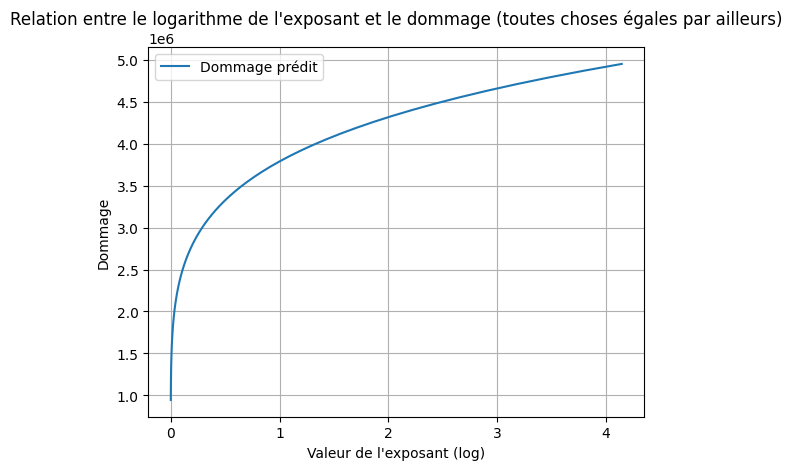

In [39]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plage de valeurs pour log_exponent (car ton modèle utilise le log de l'exposant)
log_exponent_range = np.linspace(damage_aggregated['log_exponent'].min(), 
                                 damage_aggregated['log_exponent'].max(), 100)

# Fixer les autres variables à leurs moyennes (ou à d'autres valeurs pertinentes)
mean_temperature = damage_aggregated['temperature_change'].mean()
mean_log_constant = damage_aggregated['log_constant'].mean()
mean_dice = damage_aggregated['equation_dice_tot_eq_dice_total_impact'].mean()
mean_witness = damage_aggregated['equation_witness_tot_eq_witness_total_impact'].mean()

# Générer les prédictions avec les variables log-transformées
X_pred = pd.DataFrame({
    'temperature_change': [mean_temperature] * len(log_exponent_range),
    'log_exponent': log_exponent_range,  # Utiliser log_exponent au lieu de exponent
    'log_constant': [mean_log_constant] * len(log_exponent_range),  # Utiliser log_constant
    'equation_dice_tot_eq_dice_total_impact': [mean_dice] * len(log_exponent_range),
    'equation_witness_tot_eq_witness_total_impact': [mean_witness] * len(log_exponent_range)
})

# Ajouter la constante pour le modèle
X_pred = sm.add_constant(X_pred, has_constant='add')

# Prédire les dommages log-transformés
y_pred_log = reg_global_eq_log.predict(X_pred)

# Convertir les prédictions log en dommages réels
y_pred = np.exp(y_pred_log)

exponent_range = np.exp(log_exponent_range)

# Tracer la courbe
plt.plot(exponent_range, y_pred, label='Dommage prédit')
plt.xlabel('Valeur de l\'exposant (log)')
plt.ylabel('Dommage')
plt.title('Relation entre le logarithme de l\'exposant et le dommage (toutes choses égales par ailleurs)')
plt.grid(True)
plt.legend()
plt.show()



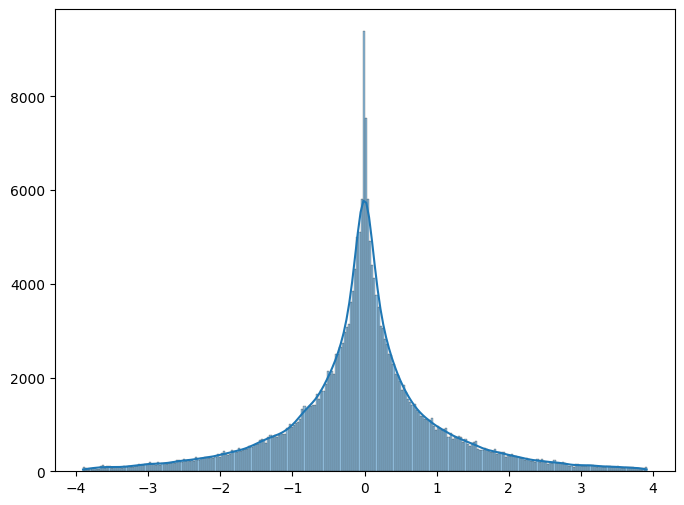

In [40]:
# Créer une figure
fig, ax = plt.subplots(figsize=(8, 6))


sns.histplot(data=data, x='log_coef', kde=True, ax=ax)

# Retirer les labels
ax.set_xlabel('')
ax.set_ylabel('')

# Enregistrer la figure
fig.savefig('../../../../Memoire/results/coef.png', dpi=300)

## TO CLEAN : previous text

### Explaining each region x time value by the choice of the model, temperature and the choice of the coefficient

Here, we test a very straight-forward model that explains the level of damage by a few straight-forward variables : 

$$

\text{Damage}_{t,r} = \beta_0 + \beta_1 \cdot GDP_{t,r} + \beta_2 \cdot \text{Temperature change} + \beta_3 \cdot coef_{t,r}
 
$$

By trials and mistake, we have come to the conclusion that using log_damage was a better use. In fact, it appears that this is just re-writting the same equation differently. 

$$

\begin{align*}
& D_{t,r} = f(\text{temperature}, \text{other drivers})_{t,r} \cdot GDP_{t,r} \cdot (\frac{y_{t,r}}{y_0})^\alpha \\
\iff  & D_{t,r} = \text{temperature}_{t,r}^{\beta_1} \cdot GDP_{t,r}^{\beta_2} \cdot \text{coef}^{\beta_3} \\
\iff & log(D_{t,r}) = log(\text{temperature}_{t,r}^{\beta_1} \cdot GDP_{t,r}^{\beta_2} \cdot \text{coef}^{\beta_3}) \\
\iff & log(D_{t,r}) = \beta_1 \cdot log(\text{temperature}_{t,r}) + \beta_2 \cdot log(GDP_{t,r}) + \beta_3 \cdot log(\text{coef})
\end{align*}

$$


In [41]:
regression_simple = sm.OLS(data['log_damage'], sm.add_constant(data[['log_temperature_change', 'log_coef', 'log_gross_domestic_product_nominal']])).fit()
regression_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_damage   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 5.954e+06
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:54:07   Log-Likelihood:                -51180.
No. Observations:              231378   AIC:                         1.024e+05
Df Residuals:                  231374   BIC:                         1.024e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -5.6403      0.004  -1355.499      0.000      -5.648      -5.632
log_temperature_change                 2.4113      0.002   1131.147      0.000       2.407       2.416
log_coef                               1.0002      0.001   1750.583      0.000       0.999       1.001
log_gross_domestic_product_nominal     1.0021      0.000   3026.896      0.000       1.001       1.003
==============================================================================
Omnibus:                    14184.200   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16945.998
Skew:                           0.659   Prob(JB):                         0.00
Kurtosis:                       3.142   Cond. No.                         89.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We find a R-squared coefficient of 0.990, which means that the variables we take into account explain 99% of the variability of the level of climate damage. This is consistent with the way the climate damages have been designed : they are precisely a combination of temperature, GDP and the coef. We have linearized the function, which was a product, by passing it through the log function. 

In [42]:
data['damage'].corr(data['coef'])

0.16234920219209228

<Axes: xlabel='log_gross_domestic_product_nominal', ylabel='log_damage'>

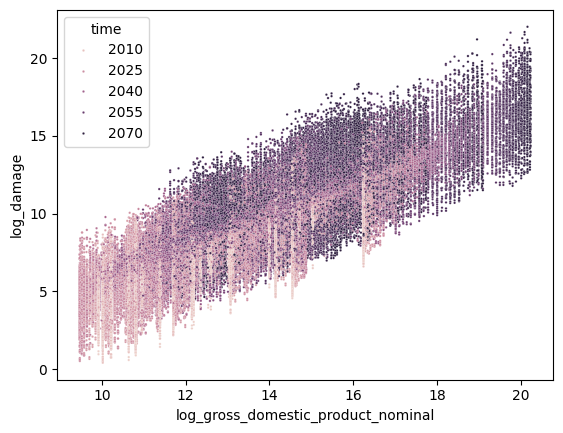

In [43]:
sns.scatterplot(data=data, x='log_gross_domestic_product_nominal', y='log_damage', hue='time', s=3)

### As aggregated data by country

Now, the thing we are being interested in is the global level of damage. Indeed, that is the metric used by SCC specialists to compute the optimal level of carbon emissions and the associated Social Cost of Carbon. 

We'll use the same dataset and sum the damages by year for every region, in order to have a global level of damage for every year. These levels of damage will be differentiated by their coef, the temperature change associated with it. 

We will then compute the following model : 

$$

\text{Global damage} = \beta_0 + \beta_1 \cdot \text{temperature change} + \beta_2 \cdot \text{coef}

$$

In [44]:
data_global = data.groupby(['time', 'equation', 'coef', 'temperature_change']).agg({'damage':'sum', 'gross_domestic_product_nominal': 'sum'}).reset_index()
data_global = pd.get_dummies(data_global, columns=['equation'])
data_global["decade"] = (data_global["time"] // 10 *10)

data_global

,time,coef,temperature_change,damage,gross_domestic_product_nominal,equation_define_tot_eq_define_total_impact,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact,decade
0,2005.0,0.021128,0.845000,1.807251e+00,4.173978e+04,True,False,False,2000.0
1,2005.0,0.022626,0.845000,9.614993e+01,2.073712e+06,True,False,False,2000.0
2,2005.0,0.023346,0.845000,4.208773e+00,8.797300e+04,True,False,False,2000.0
3,2005.0,0.026930,0.845000,2.723010e+00,4.934207e+04,True,False,False,2000.0
4,2005.0,0.026954,0.845000,1.145447e+02,2.073712e+06,True,False,False,2000.0
...,...,...,...,...,...,...,...,...,...
221512,2070.0,40.175788,1.799231,2.167032e+07,2.805715e+07,False,False,True,2070.0
221513,2070.0,40.665182,2.603701,1.019772e+07,5.838890e+06,False,False,True,2070.0
221514,2070.0,42.080334,2.603701,1.055260e+07,5.838890e+06,False,False,True,2070.0
221515,2070.0,44.251414,2.429880,3.125851e+08,1.929320e+08,False,False,True,2070.0


In [45]:

data_global["decade"] = (data_global["time"] // 10 *10)

y =  np.log(data_global['damage'])
X = data_global[['coef' , 'equation_define_tot_eq_define_total_impact',  'equation_witness_tot_eq_witness_total_impact']]

X = X.astype(float)



regression_global = sm.OLS(y, sm.add_constant(X)).fit() 
regression_global.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 damage   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                 1.114e+04
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:54:16   Log-Likelihood:            -5.1424e+05
No. Observations:              221517   AIC:                         1.028e+06
Df Residuals:                  221513   BIC:                         1.029e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            8.1349      0.009    864.478      0.000       8.116       8.153
coef                                             0.2222      0.001    177.649      0.000       0.220       0.225
equation_define_tot_eq_define_total_impact       0.1955      0.013     15.235      0.000       0.170       0.221
equation_witness_tot_eq_witness_total_impact     0.5456      0.013     42.514      0.000       0.520       0.571
==============================================================================
Omnibus:                     4410.665   Durbin-Watson:                   1.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4793.738
Skew:                           0.330   Prob(JB):                         0.00
Kurtosis:                       3.291   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Same taking into account the time : higher R squared, but strong collinearity. 

In [46]:
y =  np.log(data_global['damage'])
X = data_global[['time', 'coef' , 'equation_define_tot_eq_define_total_impact',  'equation_witness_tot_eq_witness_total_impact']]

X = X.astype(float)



regression_global = sm.OLS(y, sm.add_constant(X)).fit() 
regression_global.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 damage   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                 4.307e+04
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:54:16   Log-Likelihood:            -4.6607e+05
No. Observations:              221517   AIC:                         9.321e+05
Df Residuals:                  221512   BIC:                         9.322e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         -149.5028      0.454   -329.416      0.000    -150.392    -148.613
time                                             0.0774      0.000    347.389      0.000       0.077       0.078
coef                                             0.2000      0.001    198.360      0.000       0.198       0.202
equation_define_tot_eq_define_total_impact       0.1955      0.010     18.936      0.000       0.175       0.216
equation_witness_tot_eq_witness_total_impact     0.5456      0.010     52.840      0.000       0.525       0.566
==============================================================================
Omnibus:                     5502.010   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5920.307
Skew:                           0.396   Prob(JB):                         0.00
Kurtosis:                       3.124   Cond. No.                     2.19e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: xlabel='coef', ylabel='damage'>

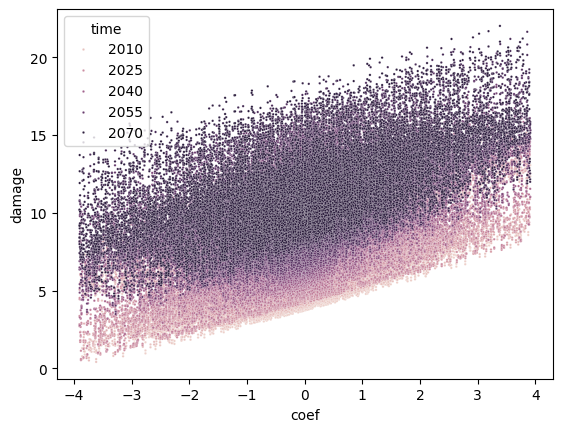

In [47]:
sns.scatterplot(data=data_global, x=np.log(data_global['coef']), y=np.log(data_global['damage']), s=3, hue='time')

<Axes: xlabel='time', ylabel='damage'>

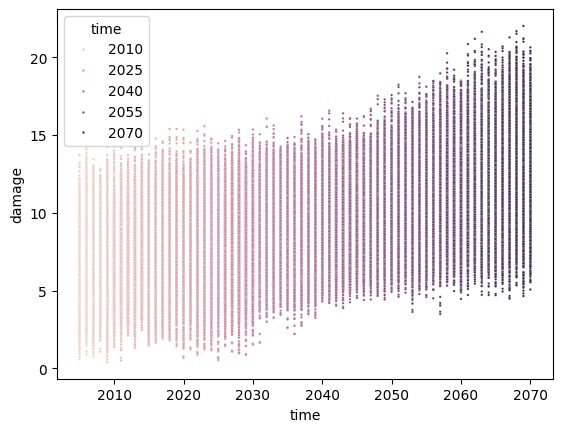

In [48]:
sns.scatterplot(data= data_global, x='time',  y=np.log(data_global['damage']), s=3, hue='time')

### Without the equation dummies

In [49]:
# Group by time, region, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()

# Create a dummy for each damage function
#df_regression = pd.get_dummies(df_regression, columns=['equation'], drop_first=False)

# Drop the null values
df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression = df_regression.dropna()

# Define the dependant variable and the independant variables
y = df_regression['damage']
X = df_regression.drop(columns=['damage', 'REGIONS 35 I', 'equation', 'coef'], axis=1)

# Add a constant to the independant variables
X = sm.add_constant(X)

# Convert the data to float
X = X.astype(float)
y = y.astype(float)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 damage   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     63.65
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           1.76e-46
Time:                        11:54:41   Log-Likelihood:                -3717.3
No. Observations:                 198   AIC:                             7451.
Df Residuals:                     190   BIC:                             7477.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                 3.679e+09   1.14e+10      0.323      0.747   -1.88e+10    2.62e+10
time                                 -1.851e+06   5.79e+06     -0.320      0.750   -1.33e+07    9.57e+06
extra_extra_exponent                  2.175e+07   2.93e+06      7.433      0.000     1.6e+07    2.75e+07
extra_extra_normalisation_constant    -342.2954    231.178     -1.481      0.140    -798.301     113.711
total_radiative_forcing               1.014e+08   1.23e+08      0.822      0.412   -1.42e+08    3.45e+08
temperature_change                   -5.229e+06   8.76e+05     -5.971      0.000   -6.96e+06    -3.5e+06
gross_domestic_product_nominal           0.4985      0.057      8.725      0.000       0.386       0.611
average_disposable_income_per_capita   -56.4282      7.403     -7.623      0.000     -71.030     -41.826
==============================================================================
Omnibus:                      102.227   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1531.108
Skew:                           1.539   Prob(JB):                         0.00
Kurtosis:                      16.271   Cond. No.                     2.14e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

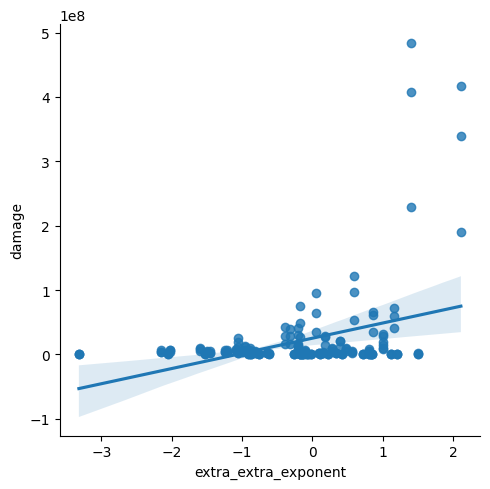

In [50]:
sns.lmplot(data=df_regression, x='extra_extra_exponent', y='damage')

### Without countries as dummy

In [51]:
# Group by time, region, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()

# Create a dummy for each damage function
df_regression = pd.get_dummies(df_regression, columns=['equation'], drop_first=True)

# Drop the null values
df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression = df_regression.dropna()

# Define the dependant variable and the independant variables
y = df_regression['damage']
X = df_regression.drop(columns=['damage', 'REGIONS 35 I', 'time', 'extra_extra_normalisation_constant', 'extra_extra_exponent', 'gross_domestic_product_nominal', 'average_disposable_income_per_capita', 'temperature_change'], axis=1)

# Add a constant to the independant variables
X = sm.add_constant(X)

# Convert the data to float
X = X.astype(float)
y = y.astype(float)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 damage   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     21.99
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           5.70e-15
Time:                        11:54:42   Log-Likelihood:                -3799.6
No. Observations:                 198   AIC:                             7609.
Df Residuals:                     193   BIC:                             7626.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                        -9.123e+07   1.55e+07     -5.883      0.000   -1.22e+08   -6.06e+07
total_radiative_forcing                       2.855e+07   4.13e+06      6.906      0.000    2.04e+07    3.67e+07
coef                                          4.339e+05   6.56e+04      6.614      0.000    3.05e+05    5.63e+05
equation_dice_tot_eq_dice_total_impact       -1.303e+07   9.21e+06     -1.415      0.159   -3.12e+07    5.13e+06
equation_witness_tot_eq_witness_total_impact -3.264e+06   9.21e+06     -0.355      0.723   -2.14e+07    1.49e+07
==============================================================================
Omnibus:                      203.854   Durbin-Watson:                   0.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4805.115
Skew:                           4.083   Prob(JB):                         0.00
Kurtosis:                      25.710   Cond. No.                         360.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# Creating the stargazer object
stargazer = Stargazer([results])

# Customizing the table
stargazer.title('Résultats de la régression')
stargazer.show_model_numbers(False)

latex_code=stargazer.render_latex()

latex_code = latex_code.replace('_', r'\_')


with open('../../../../Memoire/results/reg.tex', 'w') as f:
    f.write(latex_code)


In [53]:
df_regression

,time,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,REGIONS 35 I,coef,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,damage,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact
0,2005.0,0.845784,47058.691018,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,11.232428,24.505000,7.153753e+07,4.619347e+05,5.929256e+04,False,False
1,2005.0,0.845784,47058.691018,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,11.232428,24.505000,7.153753e+07,4.619347e+05,7.162551e+04,True,False
2,2005.0,0.845784,47058.691018,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,11.232428,24.505000,7.153753e+07,4.619347e+05,1.210243e+05,False,True
3,2006.0,-2.057845,27579.330636,1.771211,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,233.252268,23.332586,6.011960e+07,4.582531e+05,1.063262e+06,False,False
4,2006.0,-2.057845,27579.330636,1.771211,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,233.252268,23.332586,6.011960e+07,4.582531e+05,1.282744e+06,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
193,2069.0,0.048377,47394.016848,4.763925,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,30.683846,74.955826,1.382135e+09,1.028025e+07,3.502939e+07,True,False
194,2069.0,0.048377,47394.016848,4.763925,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,30.683846,74.955826,1.382135e+09,1.028025e+07,6.384389e+07,False,True
195,2070.0,-0.173258,42595.512443,4.815545,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,24.123357,75.880697,1.528983e+09,1.149219e+07,7.498757e+07,False,False
196,2070.0,-0.173258,42595.512443,4.815545,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,24.123357,75.880697,1.528983e+09,1.149219e+07,2.634244e+07,True,False


### With countries as dummy

In [54]:
# Group by time, region, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'REGIONS 35 I', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()

# Create a dummy for each damage function
df_regression = pd.get_dummies(df_regression, columns=['equation', 'REGIONS 35 I'], drop_first=True)

# Drop the null values
df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression = df_regression.dropna()

# Define the dependant variable and the independant variables
y = df_regression['damage']
X = df_regression.drop(columns=['damage'], axis=1)

# Add a constant to the independant variables
X = sm.add_constant(X)

# Convert the data to float
X = X.astype(float)
y = y.astype(float)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 damage   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     41.10
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          2.97e-265
Time:                        11:54:42   Log-Likelihood:                -97300.
No. Observations:                5595   AIC:                         1.947e+05
Df Residuals:                    5556   BIC:                         1.949e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         1.773e+08   4.49e+08      0.395      0.693   -7.03e+08    1.06e+09
time                                         -9.019e+04   2.28e+05     -0.395      0.693   -5.37e+05    3.57e+05
extra_extra_exponent                          1.085e+06   1.26e+05      8.627      0.000    8.38e+05    1.33e+06
extra_extra_normalisation_constant             -10.8982     10.401     -1.048      0.295     -31.288       9.492
total_radiative_forcing                       2.847e+06   7.12e+06      0.400      0.689   -1.11e+07    1.68e+07
coef                                          5.494e+05   3.01e+04     18.254      0.000     4.9e+05    6.08e+05
temperature_change                           -1.644e+06    7.3e+06     -0.225      0.822    -1.6e+07    1.27e+07
gross_domestic_product_nominal                   0.1027      0.004     26.960      0.000       0.095       0.110
average_disposable_income_per_capita            -2.9542      0.878     -3.363      0.001      -4.676      -1.232
equation_dice_tot_eq_dice_total_impact       -4.612e+05   2.84e+05     -1.625      0.104   -1.02e+06    9.52e+04
equation_witness_tot_eq_witness_total_impact -1.155e+05   2.84e+05     -0.407      0.684   -6.72e+05    4.41e+05
REGIONS 35 I_BULGARIA                        -7.268e+05   8.87e+05     -0.819      0.413   -2.47e+06    1.01e+06
REGIONS 35 I_CHINA                           -7.519e+05   9.89e+05     -0.760      0.447   -2.69e+06    1.19e+06
REGIONS 35 I_CROATIA                         -2.853e+05   8.82e+05     -0.323      0.746   -2.02e+06    1.44e+06
REGIONS 35 I_CYPRUS                          -1.341e+05   8.81e+05     -0.152      0.879   -1.86e+06    1.59e+06
REGIONS 35 I_CZECH REPUBLIC                   1.774e+04   8.81e+05      0.020      0.984   -1.71e+06    1.74e+06
REGIONS 35 I_DENMARK                          3.797e+05   8.88e+05      0.427      0.669   -1.36e+06    2.12e+06
REGIONS 35 I_EASOC                           -3.072e+06   8.99e+05     -3.416      0.001   -4.83e+06   -1.31e+06
REGIONS 35 I_ESTONIA                          4422.7842   8.81e+05      0.005      0.996   -1.72e+06    1.73e+06
REGIONS 35 I_FINLAND                          4.079e+05   8.88e+05      0.459      0.646   -1.33e+06    2.15e+06
REGIONS 35 I_FRANCE                          -1.578e+05    8.8e+05     -0.179      0.858   -1.88e+06    1.57e+06
REGIONS 35 I_GERMANY                         -1.028e+06   9.05e+05     -1.136      0.256    -2.8e+06    7.47e+05
REGIONS 35 I_GREECE                          -1.006e+05   8.83e+05     -0.114      0.909   -1.83e+06    1.63e+06
REGIONS 35 I_HUNGARY                         -4.439e+05   8.83e+05     -0.503      0.615   -2.18e+06    1.29e+06
REGIONS 35 I_INDIA              

### Exporting to $\LaTeX$

In [55]:
stargazer = Stargazer([results])
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{1}{c}{\\textit{Dependent variable: damage}} \\\n\\cr \\cline{2-2}\n\\\\[-1.8ex] & (1) \\\\\n\\hline \\\\[-1.8ex]\n REGIONS 35 I_BULGARIA & -726811.042$^{}$ \\\\\n& (887181.299) \\\\\n REGIONS 35 I_CHINA & -751906.998$^{}$ \\\\\n& (989150.454) \\\\\n REGIONS 35 I_CROATIA & -285324.729$^{}$ \\\\\n& (882494.943) \\\\\n REGIONS 35 I_CYPRUS & -134115.735$^{}$ \\\\\n& (880737.385) \\\\\n REGIONS 35 I_CZECH REPUBLIC & 17735.905$^{}$ \\\\\n& (880593.956) \\\\\n REGIONS 35 I_DENMARK & 379709.011$^{}$ \\\\\n& (888446.063) \\\\\n REGIONS 35 I_EASOC & -3071563.896$^{***}$ \\\\\n& (899167.471) \\\\\n REGIONS 35 I_ESTONIA & 4422.784$^{}$ \\\\\n& (880750.281) \\\\\n REGIONS 35 I_FINLAND & 407857.131$^{}$ \\\\\n& (888482.652) \\\\\n REGIONS 35 I_FRANCE & -157811.467$^{}$ \\\\\n& (880418.028) \\\\\n REGIONS 35 I_GERMANY & -1027767.048$^{}$ \\\\\n& (905059.748) \\\\\n